In [1]:
from autolens.imaging import image as im
from autolens.imaging import mask as ma
from autolens.lensing import fitting
from autolens.lensing import ray_tracing
from autolens.lensing import galaxy as g
from autolens.lensing import lensing_image as li
from autolens.profiles import light_profiles as lp
from autolens.profiles import mass_profiles as mp
from autolens.plotting import imaging_plotters
from autolens.plotting import ray_tracing_plotters
from autolens.plotting import fitting_plotters

# In this example, we'll fit the image we simulated in the previous exercise. We'll do this using model images generated
# via a tracer, and by compairing to the simulated image we'll get diagostics about the quality of the fit.

In [4]:
# First, we load the image-data we simualted in the previous tutorial.
path = 'path/to/AutoLens/howtolens/1_introduction' # Unfortunately, in a Jupyter notebook you have to manually specify the path to PyAutoLens and this tutorial.
# path = '/home/jammy/PyCharm/Projects/AutoLens/howtolens/1_introduction'
image = im.load_imaging_from_path(image_path=path + '/data/image.fits',
                                  noise_map_path=path+'/data/noise_map.fits',
                                  psf_path=path + '/data/psf.fits', pixel_scale=0.1)

In [5]:
# To fit an image, we first specify a mask. A mask describes the sections of the image that we fit. 

# Typically, we want to mask out regions of the image where the lens and source galaxies are not visible, for example
# at the edges where the signal is entirely background sky and noise.

# For the image we simulated, a 3" circular mask will do the job. 

mask = ma.Mask.circular(shape=image.shape, pixel_scale=image.pixel_scale, radius_mask_arcsec=3.0)
print(mask)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


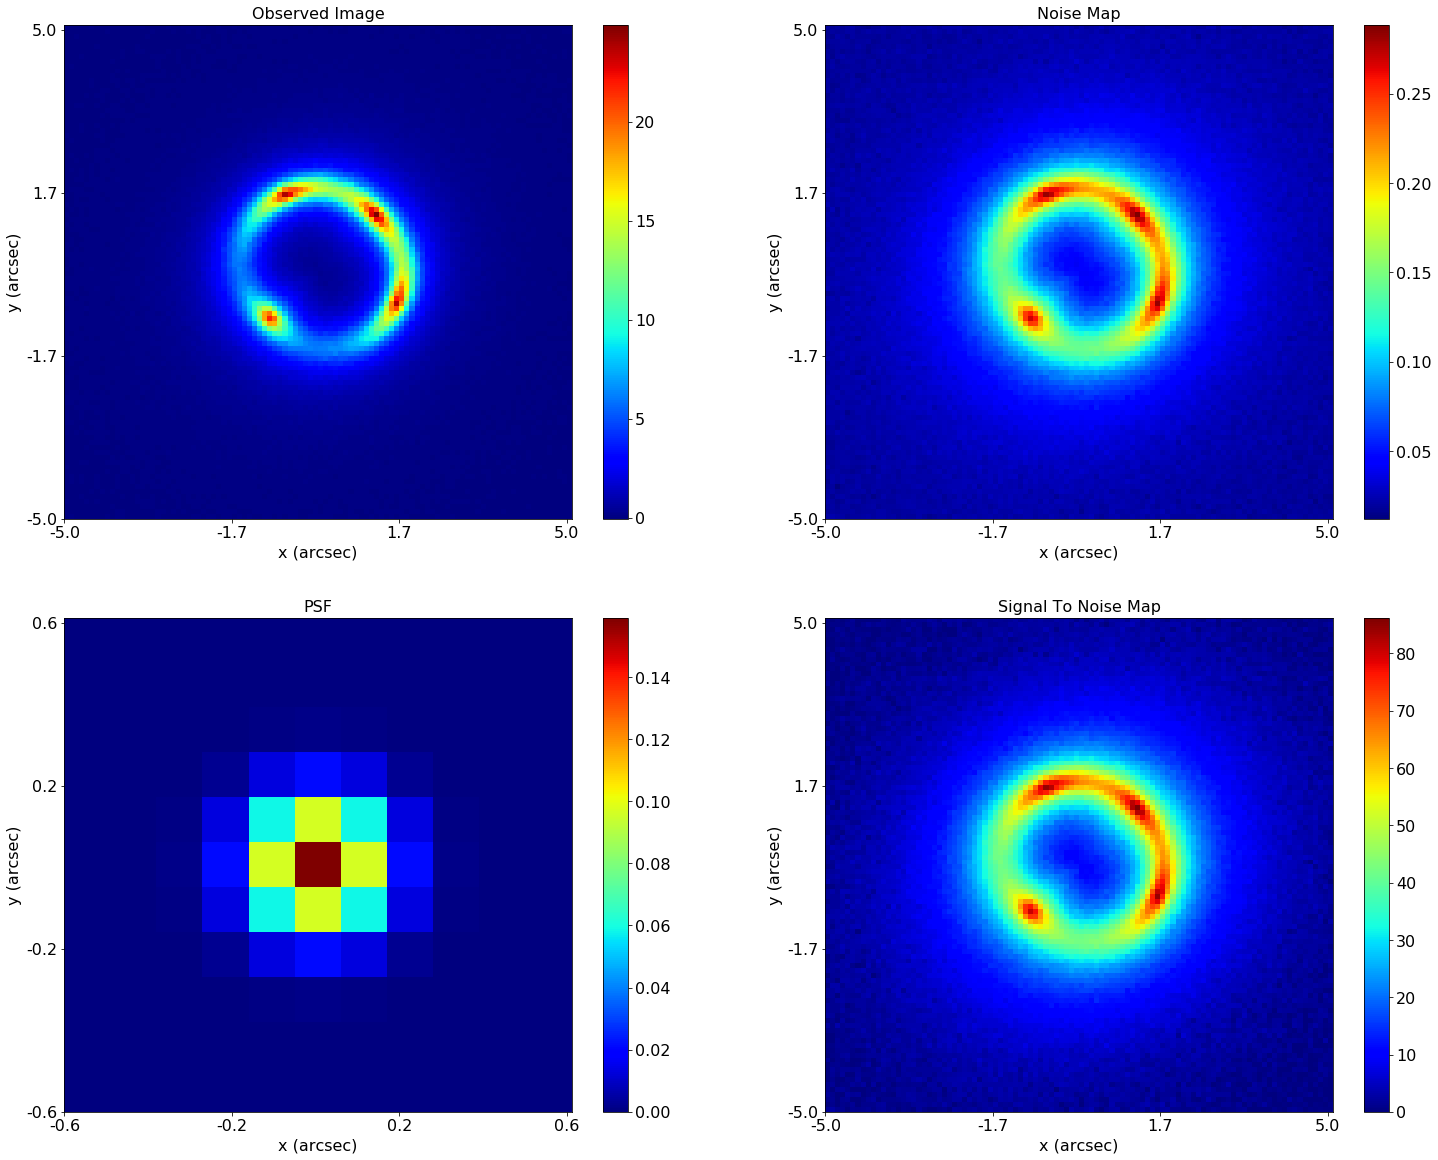

In [6]:
# Now we've loaded the image and created a mask, we use them to create a 'lensing image', which we'll perform using the
# lensing_module (imported as 'li').

# A lensing image is a 'package' of all parts of the the image data we need in order to fit it:

# 1) The image.

# 2) The PSF: so that when we compare a tracer's image-plane image to the image data we can include blurring due to 
#    the telescope optics.

# 3) The noise-map: so our goodness-of-fit measure accounts for noise in the observations.

# 4) The image's grids: so the tracer's image-plane image is generated on the same (masked) grid as the image-data.

lensing_image = li.LensingImage(image=image, mask=mask)
imaging_plotters.plot_image(lensing_image.image)

In [7]:
# By printing its attribute, we can see that it does indeed contain the image, mask, psf and so on
print('Image:')
print(lensing_image.image)
print('Noise-Map:')
print(lensing_image.image.noise_map)
print('PSF:')
print(lensing_image.image.psf)
print('Mask')
print(lensing_image.mask)
print('Grid')
print(lensing_image.grids.image)

Image:
[[ 0.00521582 -0.00065062  0.0201923  ...  0.00997482  0.01167547
   0.02343919]
 [-0.01067328  0.02018123  0.01441569 ...  0.01843967  0.0433558
   0.05500881]
 [-0.00985628 -0.00894374  0.04868634 ...  0.00698262 -0.00156033
   0.03997482]
 ...
 [ 0.02715135  0.02859833 -0.00656066 ... -0.01464699  0.01441569
  -0.00647436]
 [ 0.00249952  0.02385486  0.005265   ...  0.00772293 -0.00648543
   0.01934938]
 [ 0.03789712  0.06583285  0.03381802 ...  0.01681039  0.01266005
   0.01188248]]
Noise-Map:
[[0.0187275  0.01819793 0.02001602 ... 0.01914635 0.01929382 0.02028457]
 [0.0172556  0.0200151  0.0195291  ... 0.01986955 0.02185984 0.02273095]
 [0.01733433 0.01742185 0.02226255 ... 0.01888409 0.01811442 0.02160053]
 ...
 [0.02058732 0.02070413 0.01764836 ... 0.01686743 0.0195291  0.0176565 ]
 [0.01848418 0.0203187  0.01873188 ... 0.01894931 0.01765546 0.01994571]
 [0.02143961 0.02351119 0.02112013 ... 0.01973241 0.01937869 0.0193117 ]]
PSF:
[[2.21033495e-12 1.98968011e-10 6.58891561

In [8]:
# The shapes of these grids reveals they are 1D and have been masked:
print(lensing_image.image.shape) # This is the original 2D image
print(lensing_image.shape)
print(lensing_image.noise_map.shape)
print(lensing_image.grids.image.shape)

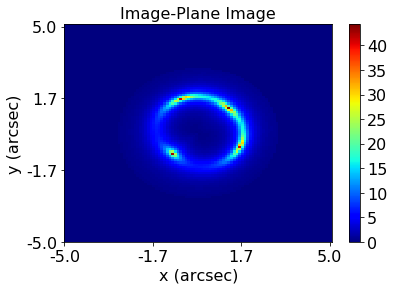

In [9]:
# To fit an image, we need to create an image-plane image using a tracer.
# Lets use the same tracer we simulated the image with (thus, our fit should be 'perfect').

# Its worth noting that below, we use the lensing_image's grids to setup the tracer. This ensures that our image-plane
# image will be the same resolution and alignment as our image-data, as well as being masked appropriately.

lens_galaxy = g.Galaxy(mass=mp.EllipticalIsothermal(centre=(0.0, 0.0), einstein_radius=1.6, axis_ratio=0.7, phi=45.0))
source_galaxy = g.Galaxy(light=lp.EllipticalSersic(centre=(0.1, 0.1), axis_ratio=0.8, phi=45.0,
                                                        intensity=1.0, effective_radius=1.0, sersic_index=2.5))
tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy], source_galaxies=[source_galaxy],
                                             image_plane_grids=lensing_image.grids)
ray_tracing_plotters.plot_ray_tracing_individual(tracer=tracer, plot_image_plane_image=True)

[[ 0.1879774   0.20597305  0.22572123  0.24733702  0.27091615  0.29652193
   0.32416821  0.35379774  0.38525617  0.41826249  0.45237838  0.48698079
   0.52124457  0.55414413  0.58448383  0.6109649   0.63229048  0.64729996
   0.65511189  0.65524586  0.64769349  0.63291973  0.61179401  0.58546964
   0.55524115  0.52240919  0.4881743   0.45356865  0.41942446  0.38637155]
 [ 0.20419003  0.22461457  0.24718038  0.27205958  0.2994083   0.32935085
   0.36195772  0.39721652  0.43499512  0.47499738  0.51671433  0.5593764
   0.60191727  0.64296429  0.68087353  0.71382543  0.73998703  0.7577272
   0.76584754  0.7637739   0.75165444  0.73033395  0.7012125   0.66603091
   0.62664021  0.58480477  0.5420666   0.49967574  0.45857541  0.41942446]
 [ 0.22160883  0.24477398  0.27055183  0.29919281  0.33093936  0.36600722
   0.40455821  0.44666186  0.49224399  0.54102132  0.59242413  0.64551426
   0.69891362  0.75076841  0.79878257  0.84035401  0.87283073  0.89386685
   0.9018085   0.89600307  0.87692917 

[[ 0.1879774   0.20597305  0.22572123  0.24733702  0.27091615  0.29652193
   0.32416821  0.35379774  0.38525617  0.41826249  0.45237838  0.48698079
   0.52124457  0.55414413  0.58448383  0.6109649   0.63229048  0.64729996
   0.65511189  0.65524586  0.64769349  0.63291973  0.61179401  0.58546964
   0.55524115  0.52240919  0.4881743   0.45356865  0.41942446  0.38637155]
 [ 0.20419003  0.22461457  0.24718038  0.27205958  0.2994083   0.32935085
   0.36195772  0.39721652  0.43499512  0.47499738  0.51671433  0.5593764
   0.60191727  0.64296429  0.68087353  0.71382543  0.73998703  0.7577272
   0.76584754  0.7637739   0.75165444  0.73033395  0.7012125   0.66603091
   0.62664021  0.58480477  0.5420666   0.49967574  0.45857541  0.41942446]
 [ 0.22160883  0.24477398  0.27055183  0.29919281  0.33093936  0.36600722
   0.40455821  0.44666186  0.49224399  0.54102132  0.59242413  0.64551426
   0.69891362  0.75076841  0.79878257  0.84035401  0.87283073  0.89386685
   0.9018085   0.89600307  0.87692917 

[[ 0.1879774   0.20597305  0.22572123  0.24733702  0.27091615  0.29652193
   0.32416821  0.35379774  0.38525617  0.41826249  0.45237838  0.48698079
   0.52124457  0.55414413  0.58448383  0.6109649   0.63229048  0.64729996
   0.65511189  0.65524586  0.64769349  0.63291973  0.61179401  0.58546964
   0.55524115  0.52240919  0.4881743   0.45356865  0.41942446  0.38637155]
 [ 0.20419003  0.22461457  0.24718038  0.27205958  0.2994083   0.32935085
   0.36195772  0.39721652  0.43499512  0.47499738  0.51671433  0.5593764
   0.60191727  0.64296429  0.68087353  0.71382543  0.73998703  0.7577272
   0.76584754  0.7637739   0.75165444  0.73033395  0.7012125   0.66603091
   0.62664021  0.58480477  0.5420666   0.49967574  0.45857541  0.41942446]
 [ 0.22160883  0.24477398  0.27055183  0.29919281  0.33093936  0.36600722
   0.40455821  0.44666186  0.49224399  0.54102132  0.59242413  0.64551426
   0.69891362  0.75076841  0.79878257  0.84035401  0.87283073  0.89386685
   0.9018085   0.89600307  0.87692917 

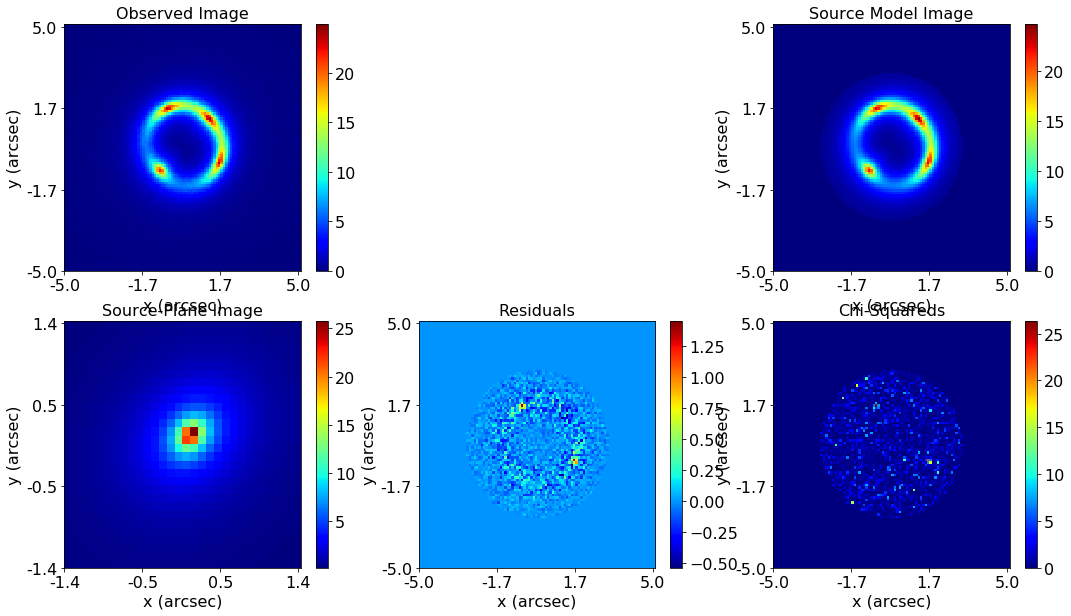

In [10]:
# To fit the image, we pass the lensing image and tracer to the fitting module. This performs the following:

# 1) Blurs the tracer's image-plane image with the lensing-image's PSF, ensuring that the telescope optics are 
#    accounted for by the fit. This creates the fit's 'model_image'.

# 2) Computes the difference between this model_image and the observed image-data, creating the fit's 'residuals'.

# 3) Divides the residuals by the noise-map and squaring each value, creating the fits 'chi-squareds'. 

# 4) Sums up these chi-squared values and converts them to a 'likelihood', which quantities how good the tracer's fit 
#    to the data was (higher likelihood = better fit).

fit = fitting.fit_lensing_image_with_tracer(lensing_image=lensing_image, tracer=tracer)
fitting_plotters.plot_fitting(fit=fit)

In [11]:
# We can print the fit's attributes:
print('Model-Image:')
print(fit.model_image)
print('Residuals:')
print(fit.residuals)
print('Chi-Squareds:')
print(fit.chi_squareds)

Model-Image:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Residuals:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Chi-Squareds:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [12]:
# It also provides a likelihood, which is a single-figure estimate of how good the model image fitted the
# simulated image.
print('Likelihood:')
print(fit.likelihood)

Likelihood:
2787.197437667772


[[ 0.18797706  0.20597268  0.22572083  0.24733659  0.27091568  0.29652143
   0.32416767  0.35379715  0.38525554  0.41826182  0.45237766  0.48698001
   0.52124374  0.55414326  0.58448291  0.61096394  0.63228949  0.64729894
   0.65511086  0.65524483  0.64769246  0.63291872  0.61179303  0.58546869
   0.55524024  0.52240832  0.48817348  0.45356788  0.41942374  0.38637088]
 [ 0.20418967  0.22461418  0.24717996  0.27205911  0.29940779  0.3293503
   0.36195712  0.39721588  0.43499442  0.47499663  0.51671352  0.55937553
   0.60191634  0.64296331  0.68087249  0.71382434  0.7399859   0.75772604
   0.76584637  0.76377272  0.75165327  0.7303328   0.70121139  0.66602984
   0.6266392   0.58480381  0.54206571  0.4996749   0.45857463  0.41942374]
 [ 0.22160844  0.24477356  0.27055137  0.29919231  0.33093881  0.36600662
   0.40455756  0.44666116  0.49224322  0.54102048  0.59242323  0.64551329
   0.69891257  0.75076729  0.79878139  0.84035276  0.87282944  0.89386552
   0.90180715  0.89600172  0.87692783

[[ 0.18797706  0.20597268  0.22572083  0.24733659  0.27091568  0.29652143
   0.32416767  0.35379715  0.38525554  0.41826182  0.45237766  0.48698001
   0.52124374  0.55414326  0.58448291  0.61096394  0.63228949  0.64729894
   0.65511086  0.65524483  0.64769246  0.63291872  0.61179303  0.58546869
   0.55524024  0.52240832  0.48817348  0.45356788  0.41942374  0.38637088]
 [ 0.20418967  0.22461418  0.24717996  0.27205911  0.29940779  0.3293503
   0.36195712  0.39721588  0.43499442  0.47499663  0.51671352  0.55937553
   0.60191634  0.64296331  0.68087249  0.71382434  0.7399859   0.75772604
   0.76584637  0.76377272  0.75165327  0.7303328   0.70121139  0.66602984
   0.6266392   0.58480381  0.54206571  0.4996749   0.45857463  0.41942374]
 [ 0.22160844  0.24477356  0.27055137  0.29919231  0.33093881  0.36600662
   0.40455756  0.44666116  0.49224322  0.54102048  0.59242323  0.64551329
   0.69891257  0.75076729  0.79878139  0.84035276  0.87282944  0.89386552
   0.90180715  0.89600172  0.87692783

[[ 0.18797706  0.20597268  0.22572083  0.24733659  0.27091568  0.29652143
   0.32416767  0.35379715  0.38525554  0.41826182  0.45237766  0.48698001
   0.52124374  0.55414326  0.58448291  0.61096394  0.63228949  0.64729894
   0.65511086  0.65524483  0.64769246  0.63291872  0.61179303  0.58546869
   0.55524024  0.52240832  0.48817348  0.45356788  0.41942374  0.38637088]
 [ 0.20418967  0.22461418  0.24717996  0.27205911  0.29940779  0.3293503
   0.36195712  0.39721588  0.43499442  0.47499663  0.51671352  0.55937553
   0.60191634  0.64296331  0.68087249  0.71382434  0.7399859   0.75772604
   0.76584637  0.76377272  0.75165327  0.7303328   0.70121139  0.66602984
   0.6266392   0.58480381  0.54206571  0.4996749   0.45857463  0.41942374]
 [ 0.22160844  0.24477356  0.27055137  0.29919231  0.33093881  0.36600662
   0.40455756  0.44666116  0.49224322  0.54102048  0.59242323  0.64551329
   0.69891257  0.75076729  0.79878139  0.84035276  0.87282944  0.89386552
   0.90180715  0.89600172  0.87692783

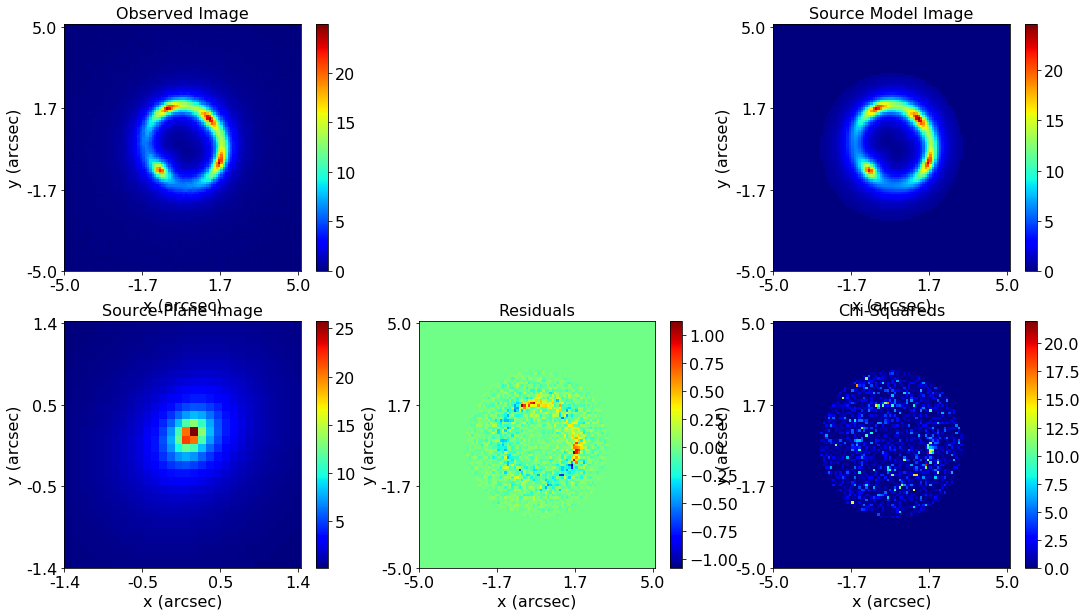

In [19]:
# We used the same tracer to create and fit the image. Therefore, our fit to the image was excellent.
# For example, by inspecting the residuals and chi-squareds, one can see no signs of the source galaxy's light present
# and we only see the noise that we simulated the image with.

# This solution should translate to one of the highest-likelihood solutions possible.

# Lets change the tracer, so that it's near the correct solution, but slightly off. 
# All we're going to do is slightly offset the lens galaxy, by 0.005"

lens_galaxy = g.Galaxy(mass=mp.EllipticalIsothermal(centre=(0.005, 0.005), einstein_radius=1.6, axis_ratio=0.7, phi=45.0))
source_galaxy = g.Galaxy(light=lp.EllipticalSersic(centre=(0.1, 0.1), axis_ratio=0.8, phi=45.0,
                                                        intensity=1.0, effective_radius=1.0, sersic_index=2.5))
tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy], source_galaxies=[source_galaxy],
                                             image_plane_grids=lensing_image.grids)
fit = fitting.fit_lensing_image_with_tracer(lensing_image=lensing_image, tracer=tracer)
fitting_plotters.plot_fitting(fit=fit)

In [14]:
# We now observe residuals to appear at the locations the source galaxy was observed, which 
# corresponds to an increase in our chi-squareds (which determines our goodness-of-fit).

# Lets compare the likelihood to the value we computed above (which was 11697.24):
print('Previous Likelihood:')
print(11697.24)
print('New Likelihood:')
print(fit.likelihood)
# It decreases! This model was a worse fit to the data.

Previous Likelihood:
11697.24
New Likelihood:
2576.9403179626534


[[8.61964438e-03 9.50416178e-03 1.04784144e-02 1.15484691e-02
  1.27195215e-02 1.39953342e-02 1.53775252e-02 1.68646983e-02
  1.84514266e-02 2.01271303e-02 2.18749286e-02 2.36706006e-02
  2.54818463e-02 2.72680920e-02 2.89811037e-02 3.05666443e-02
  3.19672993e-02 3.31264021e-02 3.39927324e-02 3.45253973e-02
  3.46981296e-02 3.45022258e-02 3.39475500e-02 3.30613973e-02
  3.18854499e-02 3.04714180e-02 2.88761485e-02 2.71569612e-02
  2.53677854e-02 2.35564085e-02]
 [9.81543519e-03 1.08802548e-02 1.20625561e-02 1.33720459e-02
  1.48176560e-02 1.64067808e-02 1.81442631e-02 2.00310963e-02
  2.20628382e-02 2.42277707e-02 2.65049165e-02 2.88621184e-02
  3.12545083e-02 3.36238142e-02 3.58990273e-02 3.79989250e-02
  3.98367511e-02 4.13269680e-02 4.23934462e-02 4.29779005e-02
  4.30470234e-02 4.25968114e-02 4.16530963e-02 4.02681584e-02
  3.85142030e-02 3.64751109e-02 3.42380475e-02 3.18862453e-02
  2.94937461e-02 2.71223242e-02]
 [1.11864103e-02 1.24710087e-02 1.39098894e-02 1.55183272e-02
  1.

[[8.61964438e-03 9.50416178e-03 1.04784144e-02 1.15484691e-02
  1.27195215e-02 1.39953342e-02 1.53775252e-02 1.68646983e-02
  1.84514266e-02 2.01271303e-02 2.18749286e-02 2.36706006e-02
  2.54818463e-02 2.72680920e-02 2.89811037e-02 3.05666443e-02
  3.19672993e-02 3.31264021e-02 3.39927324e-02 3.45253973e-02
  3.46981296e-02 3.45022258e-02 3.39475500e-02 3.30613973e-02
  3.18854499e-02 3.04714180e-02 2.88761485e-02 2.71569612e-02
  2.53677854e-02 2.35564085e-02]
 [9.81543519e-03 1.08802548e-02 1.20625561e-02 1.33720459e-02
  1.48176560e-02 1.64067808e-02 1.81442631e-02 2.00310963e-02
  2.20628382e-02 2.42277707e-02 2.65049165e-02 2.88621184e-02
  3.12545083e-02 3.36238142e-02 3.58990273e-02 3.79989250e-02
  3.98367511e-02 4.13269680e-02 4.23934462e-02 4.29779005e-02
  4.30470234e-02 4.25968114e-02 4.16530963e-02 4.02681584e-02
  3.85142030e-02 3.64751109e-02 3.42380475e-02 3.18862453e-02
  2.94937461e-02 2.71223242e-02]
 [1.11864103e-02 1.24710087e-02 1.39098894e-02 1.55183272e-02
  1.

[[8.61964438e-03 9.50416178e-03 1.04784144e-02 1.15484691e-02
  1.27195215e-02 1.39953342e-02 1.53775252e-02 1.68646983e-02
  1.84514266e-02 2.01271303e-02 2.18749286e-02 2.36706006e-02
  2.54818463e-02 2.72680920e-02 2.89811037e-02 3.05666443e-02
  3.19672993e-02 3.31264021e-02 3.39927324e-02 3.45253973e-02
  3.46981296e-02 3.45022258e-02 3.39475500e-02 3.30613973e-02
  3.18854499e-02 3.04714180e-02 2.88761485e-02 2.71569612e-02
  2.53677854e-02 2.35564085e-02]
 [9.81543519e-03 1.08802548e-02 1.20625561e-02 1.33720459e-02
  1.48176560e-02 1.64067808e-02 1.81442631e-02 2.00310963e-02
  2.20628382e-02 2.42277707e-02 2.65049165e-02 2.88621184e-02
  3.12545083e-02 3.36238142e-02 3.58990273e-02 3.79989250e-02
  3.98367511e-02 4.13269680e-02 4.23934462e-02 4.29779005e-02
  4.30470234e-02 4.25968114e-02 4.16530963e-02 4.02681584e-02
  3.85142030e-02 3.64751109e-02 3.42380475e-02 3.18862453e-02
  2.94937461e-02 2.71223242e-02]
 [1.11864103e-02 1.24710087e-02 1.39098894e-02 1.55183272e-02
  1.

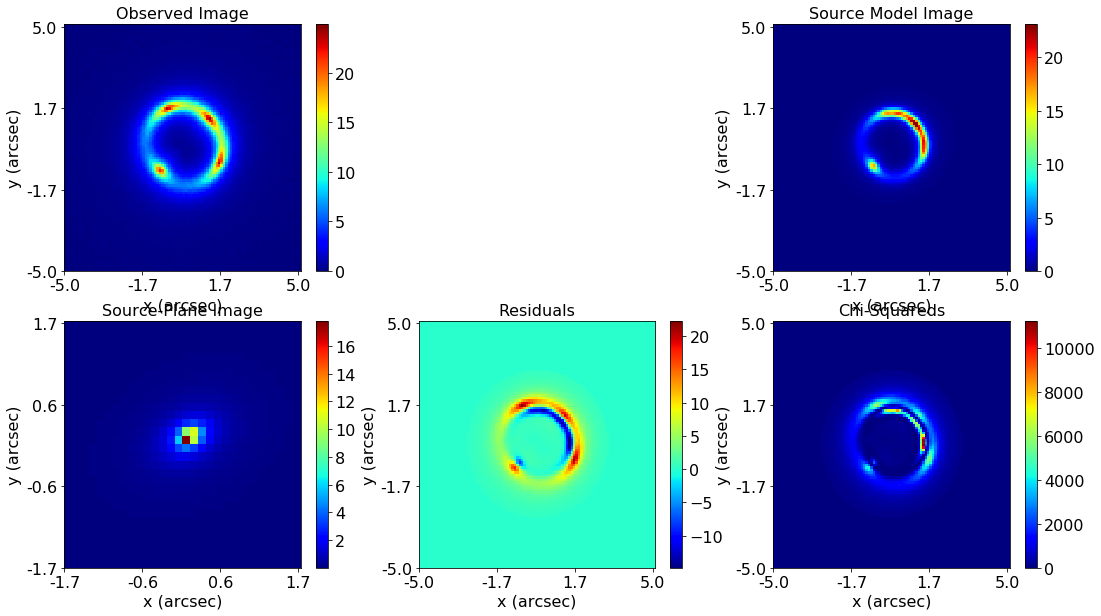

In [21]:
# Lets change the tracer, one more time, to a solution that is nowhere near the correct one.
lens_galaxy = g.Galaxy(mass=mp.EllipticalIsothermal(centre=(0.005, 0.005), einstein_radius=1.3, axis_ratio=0.8, phi=45.0))
source_galaxy = g.Galaxy(light=lp.EllipticalSersic(centre=(0.1, 0.1), axis_ratio=0.7, phi=65.0,
                                                        intensity=1.0, effective_radius=0.4, sersic_index=3.5))
tracer = ray_tracing.TracerImageSourcePlanes(lens_galaxies=[lens_galaxy], source_galaxies=[source_galaxy],
                                             image_plane_grids=lensing_image.grids)
fit = fitting.fit_lensing_image_with_tracer(lensing_image=lensing_image, tracer=tracer)
fitting_plotters.plot_fitting(fit=fit)


In [16]:
# Clearly, the model provides a terrible fit, and this tracer is not a plausible representation of 
# the image-data  (of course, we already knew that, given that we simulated it!)

# The likelihood drops dramatically, as expected.
print('Previous Likelihoods:')
print(11697.24)
print(10319.44)
print('New Likelihood:')
print(fit.likelihood)

Previous Likelihoods:
11697.24
10319.44
New Likelihood:
-1034572.8713935864


In [17]:
# Congratulations, you've fitted your first strong lens with PyAutoLens! Perform the following exercises:

# 1) In this example, we 'knew' the correct solution, because we simulated the lens ourselves. In the real Universe,
#    we have no idea what the correct solution is. How would you go about finding the correct solution? 
#    Could you find a solution that fits the data reasonable through trial and error?
